## Gender Bias  Classification Modeling as a Foundation for Headline Objectivity

Madeline F. Birch | November 2023 | Flatiron School Data Science Program | Final Capstone Project

# Contents
1. [Project Overview](#Project_Overview)
2. [The Dataset](#The_Dataset)
3. [Exploratory Data Analysis](#EDA)
4. [Feature Engineering (and more EDA)](#Feature_Engineering)
5. [Preprocessing](#Preprocessing)
6. [Train Test Split](#Train_Test_Split)




# Project Overview<a id='Project_Overview'></a>

In an era where information shapes perspectives, the media plays a pivotal role in influencing societal narratives. Understanding the subtle nuances and potential biases embedded in headlines is crucial, and this project aims to shed light on the degree of bias present in headlines. Focusing on data classification through machine learning, the project seeks to predict headlines into three classes: No Bias, Low Bias, and High Bias. The objective is not to scrutinize sensationalism or analyze sentiment polarity but rather to leverage textual and numerical features to predict the bias level accurately.

<img src="Images/pbs_logo.png" alt="PBS Logo" width="400"/>

### Our Stakeholder: PBS News
The significance of this project lies in its potential impact on journalism's objectivity, particularly for PBS News, a revered American news source known for its impartiality and lack of apparent agenda. Publicly funded by 15%, the entity continuously faces accusations of general bias and [threats of defunding from various actors](https://www.nytimes.com/2011/02/28/business/media/28cpb.html). 

By adopting insights gained from our efforts, PBS News can *silence these threats* and *secure its value* as a trusted source for objective, unbiased headlines.

### Our Vision: Gender Bias in Headlines as a Framework
We chose to focus on gender bias as a focus for this project because it is undeniably one of the most prevalent forms of bias in published news content. A 2021 Topic Modeling [study](https://www.frontiersin.org/articles/10.3389/frai.2021.664737/full) found women are unfortunately but not unexpectedly *mentioned* "more frequently in topics related to lifestyle, healthcare, and crimes and sexual assault." Another 2021 Natural Language Processing [study](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0245533) concluded, "although
we see a certain tokenism in having female *voices* present in the news, their voices are drowned
out by the overwhelming number of times that we hear from men, often from just a handful of
men." There's no denying that gender bias is present in news article content, both in references toward and quotations credited to women, but what about the content of *headlines?* Couldn't headlines about women be biased, too?

At the heart of this initiative is the recognition of headlines as powerful agents that shape our perceptions. These succinct phrases captivate our attention and mold our subconscious understanding of entire articles. The urgency to prove and maintain neutrality, especially on a platform as eminent as PBS, underscores the relevance of our undertaking.

While our primary focus is on demonstrating which ML algorithms are most adept at detecting gender bias in headlines, this project could serve a framework for ongoing assessments of headlines across diverse bias types, including political, racial, LGBTQ+, socioeconomic class and beyond. The broader vision is to contribute to a media landscape characterized by transparency, objectivity, and accountability, fostering a public discourse grounded in fair and unbiased reporting.

# The Dataset<a id='The_Dataset'></a>

The dataset utilized in this project originates from a comprehensive collection of data scraped for ["When Women Make Headlines,"](https://pudding.cool/2022/02/women-in-headlines/) a visual essay published by [*The Pudding*](https://pudding.cool/) in June 2022. Released by [Amber Thomas](https://data.world/amberthomas) on [data.world](https://data.world/the-pudding/women-in-headlines), this dataset is one of few open source datasets we could find that investigates gender bias specifically in headlines. It encompasses a diverse array of headlines about women, each annotated with corresponding bias scores. Bias scores were calculated following the methodology outlined in ["Proposed Taxonomy for Gender Bias in Text; A Filtering Methodology for the Gender Generalization Subtype."](https://aclanthology.org/W19-3802.pdf)

The dataset's origin in a visual essay adds an element of real-world applicability, grounding the project in the practical considerations of media consumption and perception. Its richness lies in its amalgamation of both textual numerical features associated with each headline. The text data provides the linguistic context of the headlines, while numerical features offer additional dimensions for analysis. This holistic approach enables the development of a machine learning model that can discern patterns beyond linguistic constructs, contributing to a nuanced understanding of what contributes to bias. 

### Our Working File
The dataset contains a multitude of `.csv` files; for the sake of simplicity, we will be working exclusively with `headlines.csv` and engineering additional numerical features to bolster our models.

### Our Target
Our target variable will be `bias`.

# Exploratory Data Analysis<a id='EDA'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import datetime
from nltk.corpus import stopwords
import gensim
import gensim.downloader
from gensim.utils import simple_preprocess

In [2]:
# Loading 'headlines.csv' into a Pandas DataFrame
headlines = pd.read_csv('Data/headlines.csv')

# Showing first 5 rows of the DataFrame
headlines.head()

,index,Unnamed: 0,url,headline_no_site,site,time,country,bias
0,0,0,https://www.iol.co.za/entertainment/movies-the...,'Lady Bird' buzzes through young sexuality,iol.co.za,2018-02-23 08:00:00+00:00,South Africa,0.000000
1,1,1,https://www.iol.co.za/entertainment/music/the-...,The shadowy urban POP super Starrah who loves ...,iol.co.za,2018-01-10 08:00:00+00:00,South Africa,0.166667
2,2,2,https://www.iol.co.za/entertainment/celebrity-...,Rihanna pens heartfelt tribute to her mom in b...,iol.co.za,2018-02-21 08:00:00+00:00,South Africa,0.333333
3,3,3,https://www.iol.co.za/news/south-africa/wester...,Shock as woman accused of killing teen girlfri...,iol.co.za,2018-02-27 08:00:00+00:00,South Africa,0.333333
4,4,4,https://www.iol.co.za/business-report/careers/...,TOP STORY: Meet South Africa's new first lady ...,iol.co.za,2018-02-15 08:00:00+00:00,South Africa,0.166667


In [3]:
# Dropping irrelevant columns 'url', 'Unnamed: 0', and 'index'
headlines = headlines.drop(columns=['url', 'Unnamed: 0', 'index'])

In [4]:
# Getting the shape of our DataFrame
headlines.shape

(382139, 5)

In [5]:
# Getting primary statistics
headlines.describe()

,bias
count,382139.000000
mean,0.171057
std,0.101210
min,0.000000
25%,0.166667
50%,0.166667
75%,0.166667
max,1.000000


In [6]:
# Getting value counts for bias feature
headlines['bias'].value_counts()

bias
0.166667    265271
0.000000     57227
0.333333     52629
0.500000      6408
0.666667       568
0.833333        35
1.000000         1
Name: count, dtype: int64

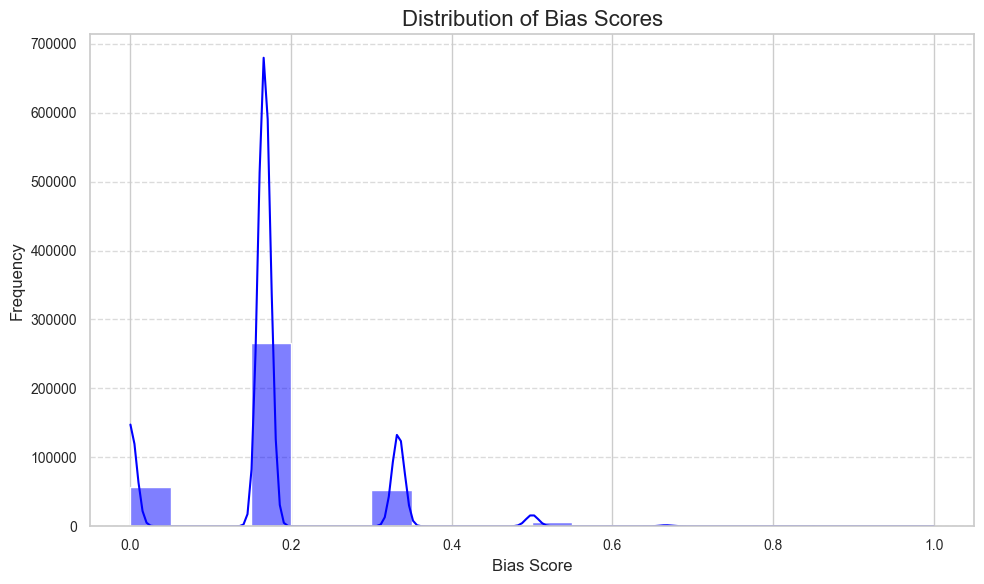

In [7]:
# Plotting bias distribution

# Setting Seaborn style
sns.set(style="whitegrid")

# Plotting histogram of 'bias'
plt.figure(figsize=(10, 6))
sns.histplot(headlines['bias'], bins=20, kde=True, color='blue')

# Styling the plot
plt.title('Distribution of Bias Scores', fontsize=16)
plt.xlabel('Bias Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Showing the plot
plt.tight_layout()
plt.show()

# Feature Engineering (and more EDA) <a id='Feature_Engineering'></a>

In [8]:
# Creating feature 'sentiment_polarity'- scale of -1 to 1

# Creating a sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Applying the sentiment analyzer to each headline and storing the compound score - this takes a while to run
headlines['sentiment_polarity'] = headlines['headline_no_site'].apply(lambda x: sid.polarity_scores(x)['compound'])

In [9]:
# Getting distribution of sentiment_polarity
headlines['sentiment_polarity'].value_counts()

sentiment_polarity
 0.0000    127683
-0.2960      6871
 0.4019      5231
-0.4767      4682
-0.3182      4423
            ...  
 0.6075         1
-0.4690         1
 0.5991         1
 0.7854         1
 0.4388         1
Name: count, Length: 4977, dtype: int64

In [10]:
# Printing min and max values for sentiment polarity
print(headlines['sentiment_polarity'].min())
print(headlines['sentiment_polarity'].max())

-0.979
0.9682


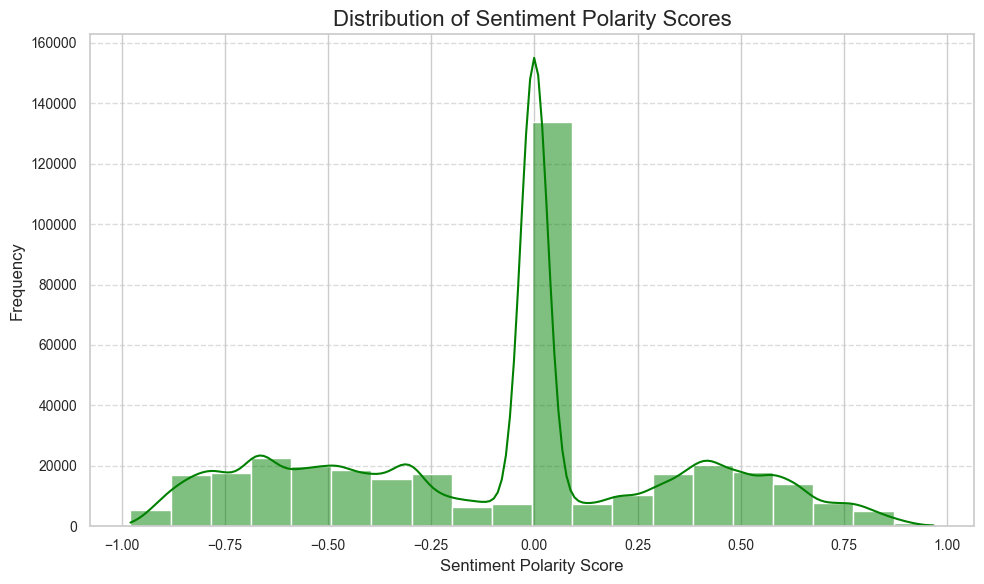

In [11]:
# Plotting dist of sentiment polarity

# Setting Seaborn style
sns.set(style="whitegrid")

# Plotting histogram of 'sentiment_polarity'
plt.figure(figsize=(10, 6))
sns.histplot(headlines['sentiment_polarity'], bins=20, kde=True, color='green')

# Styling the plot
plt.title('Distribution of Sentiment Polarity Scores', fontsize=16)
plt.xlabel('Sentiment Polarity Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Showing the plot
plt.tight_layout()
plt.show()

In [12]:
# Engineering 'Day of the Week' and 'Month' Features
headlines['Day_of_Week'] = pd.to_datetime(headlines['time']).dt.day_name()
headlines['Month'] = pd.to_datetime(headlines['time']).dt.month

# Engineering 'Hour of Dat' feature
headlines['Hour_of_Day'] = pd.to_datetime(headlines['time']).dt.hour

# Converting 'time' column to datetime format
headlines['time'] = pd.to_datetime(headlines['time'], errors='coerce')

# Extracting the year and creating a new 'Publication Year' feature
headlines['Publication_Year'] = headlines['time'].dt.year

In [13]:
# Dropping time column
headlines = headlines.drop(columns=['time'])

In [14]:
# Creating word count feature
headlines['Word_Count'] = headlines['headline_no_site'].apply(lambda x: len(x.split()))

# Creating text length feature
headlines['Text_Length'] = headlines['headline_no_site'].apply(len)

In [15]:
# Inspecting new head
headlines.head()

,headline_no_site,site,country,bias,sentiment_polarity,Day_of_Week,Month,Hour_of_Day,Publication_Year,Word_Count,Text_Length
0,'Lady Bird' buzzes through young sexuality,iol.co.za,South Africa,0.000000,0.0000,Friday,2,8,2018,6,42
1,The shadowy urban POP super Starrah who loves ...,iol.co.za,South Africa,0.166667,0.8225,Wednesday,1,8,2018,10,57
2,Rihanna pens heartfelt tribute to her mom in b...,iol.co.za,South Africa,0.333333,0.5423,Wednesday,2,8,2018,10,58
3,Shock as woman accused of killing teen girlfri...,iol.co.za,South Africa,0.333333,-0.7184,Tuesday,2,8,2018,11,65
4,TOP STORY: Meet South Africa's new first lady ...,iol.co.za,South Africa,0.166667,0.3680,Thursday,2,8,2018,10,62


In [16]:
# Getting value counts for site
headlines['site'].value_counts()

site
dailymail.co.uk    8219
telegraph.co.uk    7596
abcnews.go.com     6305
indiatimes.com     6269
mirror.co.uk       6207
                   ... 
news.google.com       4
makeuseof.com         3
howtogeek.com         3
pcadvisor.co.uk       1
dailysun.co.za        1
Name: count, Length: 186, dtype: int64

In [17]:
# Setting a threshold for news sites with at least 5000 headlines
min_headlines_threshold = 5000
top_sites = headlines['site'].value_counts()
top_sites = top_sites[top_sites >= min_headlines_threshold].index

# Creating a new dataframe with only the sites with at least 5000 headlines
headlines_filtered = headlines[headlines['site'].isin(top_sites)].copy()

In [18]:
# Getting value counts for country
headlines_filtered['country'].value_counts()

country
UK       42593
USA      39050
India    36306
Name: count, dtype: int64

/var/folders/xl/6sfvtvk54y1982txcc62tyqw0000gn/T/ipykernel_6391/1489788177.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='country', data=headlines_filtered, palette='viridis')


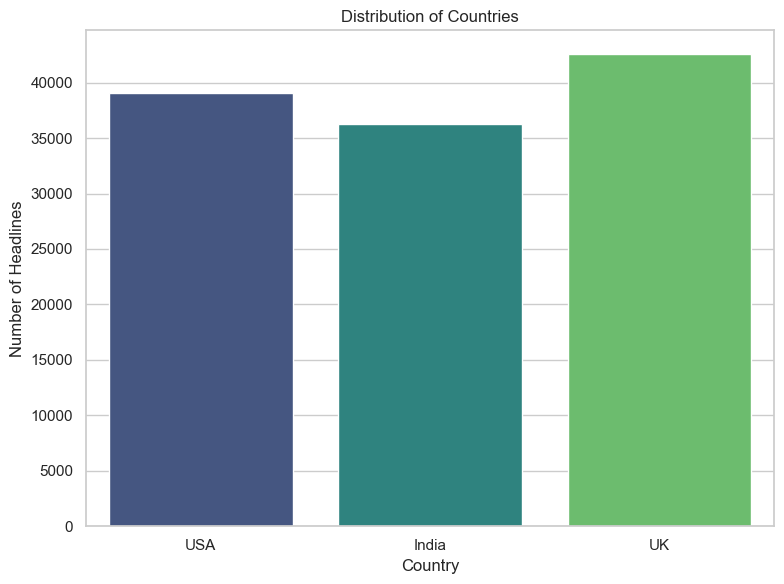

In [19]:
# Getting distribution of countries
plt.figure(figsize=(8, 6))
sns.countplot(x='country', data=headlines_filtered, palette='viridis')
plt.title('Distribution of Countries')
plt.xlabel('Country')
plt.ylabel('Number of Headlines')
plt.tight_layout()

# Showing the plot
plt.show()

In [20]:
# Filtering out all data for 'UK' and 'India' so that we stay in the US
headlines_filtered = headlines_filtered[headlines_filtered['country'].isin(['USA'])]

# Verify the changes
print(headlines_filtered['country'].value_counts())

country
USA    39050
Name: count, dtype: int64


In [21]:
# Getting shape of new DataFrame
headlines_filtered.shape

(39050, 11)

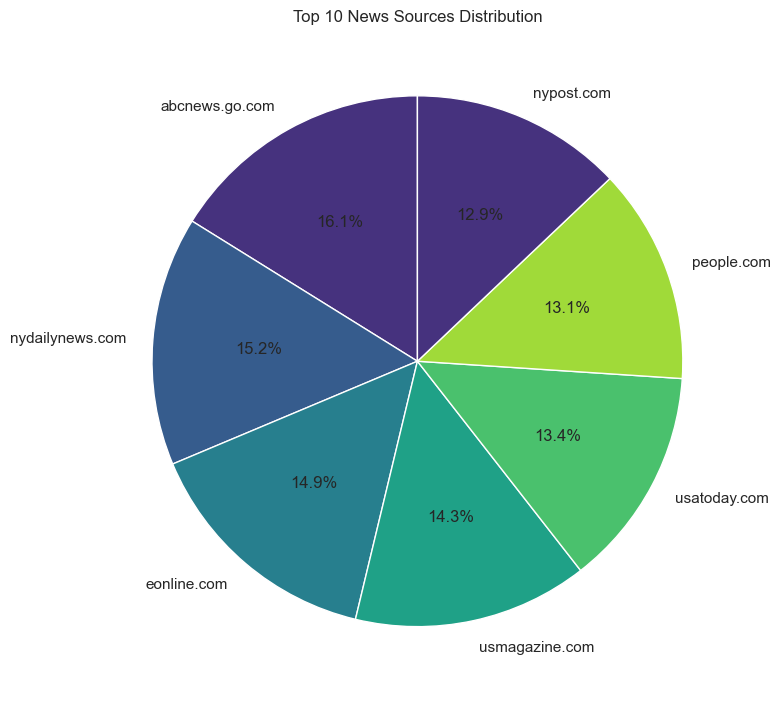

In [22]:
# Getting top 10 sites with most headlines
top_10_sites = headlines_filtered['site'].value_counts().nlargest(10)

# Creating a pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_10_sites, labels=top_10_sites.index, autopct='%1.1f%%', colors=sns.color_palette('viridis'), startangle=90)
plt.title('Top 10 News Sources Distribution')
plt.tight_layout()

# Showing the plot
plt.show()

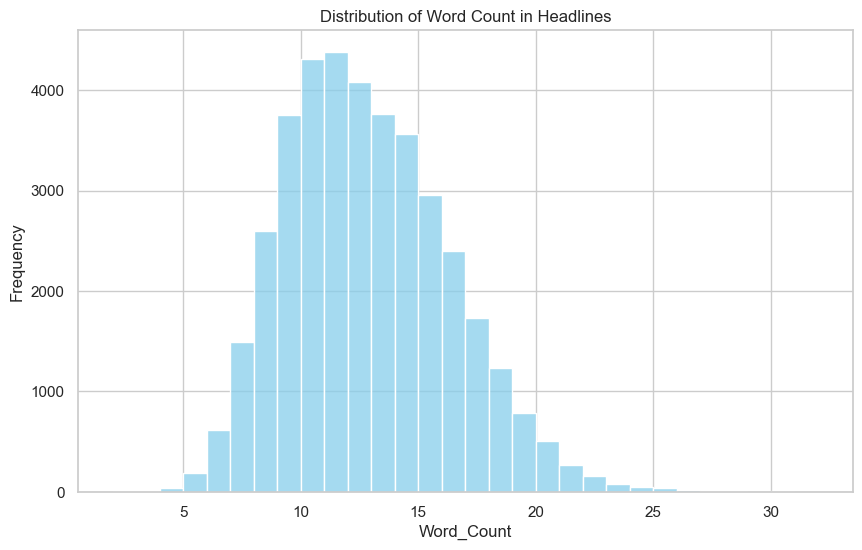

In [23]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(headlines_filtered['Word_Count'], bins=30, color='skyblue', kde=False)
plt.title('Distribution of Word Count in Headlines')
plt.xlabel('Word_Count')
plt.ylabel('Frequency')

# Show the plot
plt.show()

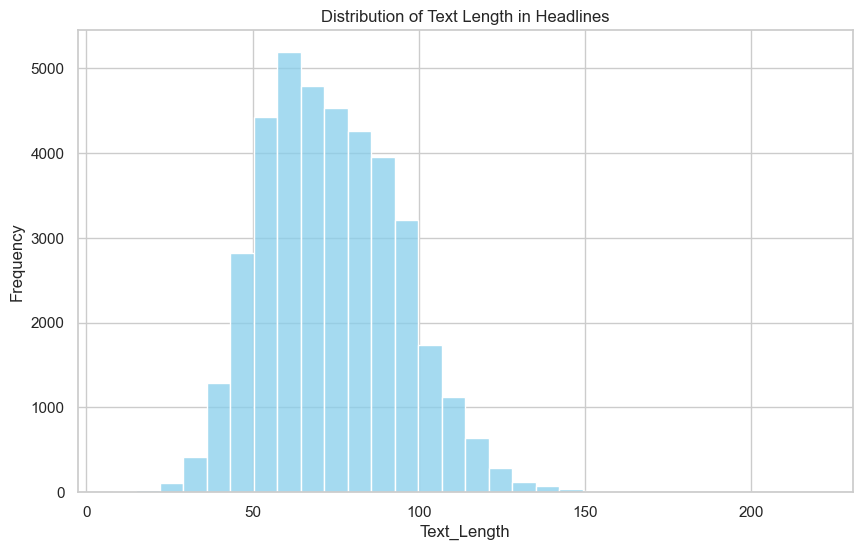

In [24]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(headlines_filtered['Text_Length'], bins=30, color='skyblue', kde=False)
plt.title('Distribution of Text Length in Headlines')
plt.xlabel('Text_Length')
plt.ylabel('Frequency')

# Show the plot
plt.show()

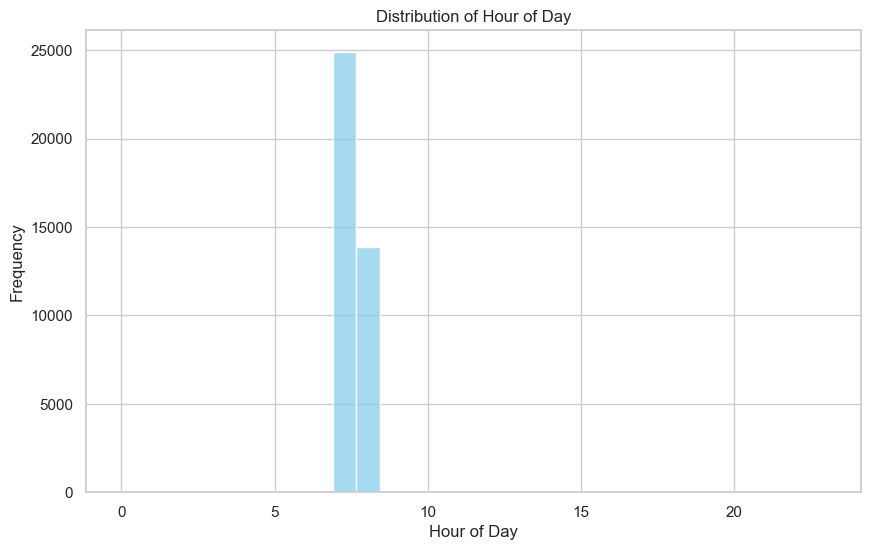

In [25]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(headlines_filtered['Hour_of_Day'], bins=30, color='skyblue', kde=False)
plt.title('Distribution of Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')

# Show the plot
plt.show()

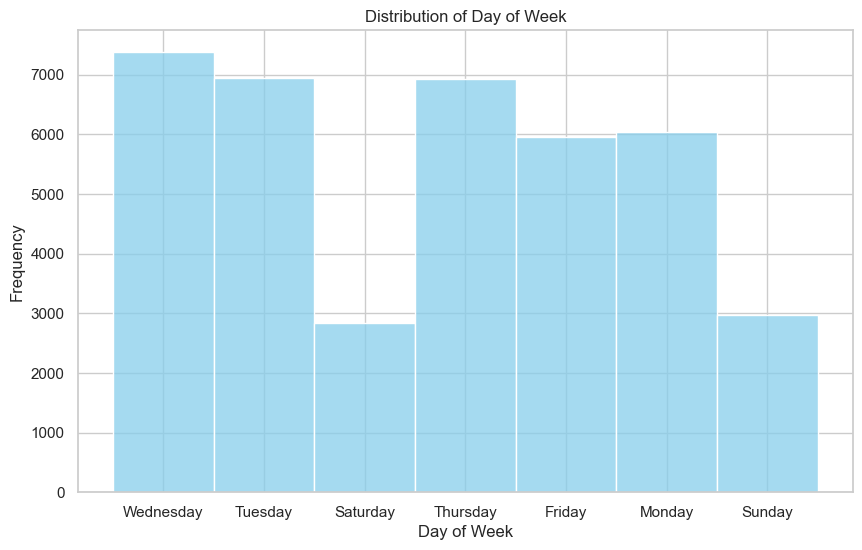

In [26]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(headlines_filtered['Day_of_Week'], bins=30, color='skyblue', kde=False)
plt.title('Distribution of Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [27]:
# Getting distribution of bias in headlines_filtered
headlines_filtered['bias'].value_counts()

bias
0.166667    26343
0.333333     6576
0.000000     5041
0.500000      982
0.666667      104
0.833333        4
Name: count, dtype: int64

In [28]:
# Setting values to drop
values_to_drop = [0.666667, 0.833333]

# Use boolean indexing to drop rows with specified values in 'bias' column
headlines_filtered = headlines_filtered[~headlines_filtered['bias'].isin(values_to_drop)]

In [29]:
# Defining conditions
conditions = [
    headlines_filtered['bias'].between(0.000000, 0.000000, inclusive='both'),
    headlines_filtered['bias'].between(0.1, 0.2, inclusive='both'),
    headlines_filtered['bias'].between(0.3, 0.5, inclusive='both'),
]

# Setting category labels
labels = ['No Bias', 'Low Bias', 'High Bias']

# Applying conditions
headlines_filtered['bias_category'] = np.select(conditions, labels, default=None)

In [30]:
# Getting unique bias category values
headlines_filtered['bias_category'].unique()

array(['High Bias', 'Low Bias', 'No Bias', None], dtype=object)

In [31]:
headlines_filtered['bias_category'].isnull().sum()

108

In [32]:
headlines_filtered = headlines_filtered.dropna()

In [33]:
headlines_filtered.isnull().sum()

headline_no_site      0
site                  0
country               0
bias                  0
sentiment_polarity    0
Day_of_Week           0
Month                 0
Hour_of_Day           0
Publication_Year      0
Word_Count            0
Text_Length           0
bias_category         0
dtype: int64

In [34]:
headlines_filtered['bias_category'].value_counts()

bias_category
Low Bias     26343
High Bias     7558
No Bias       5041
Name: count, dtype: int64

In [35]:
headlines_filtered.shape

(38942, 12)

In [36]:
# Dropping original bias column
headlines_filtered = headlines_filtered.drop(columns=['bias'])

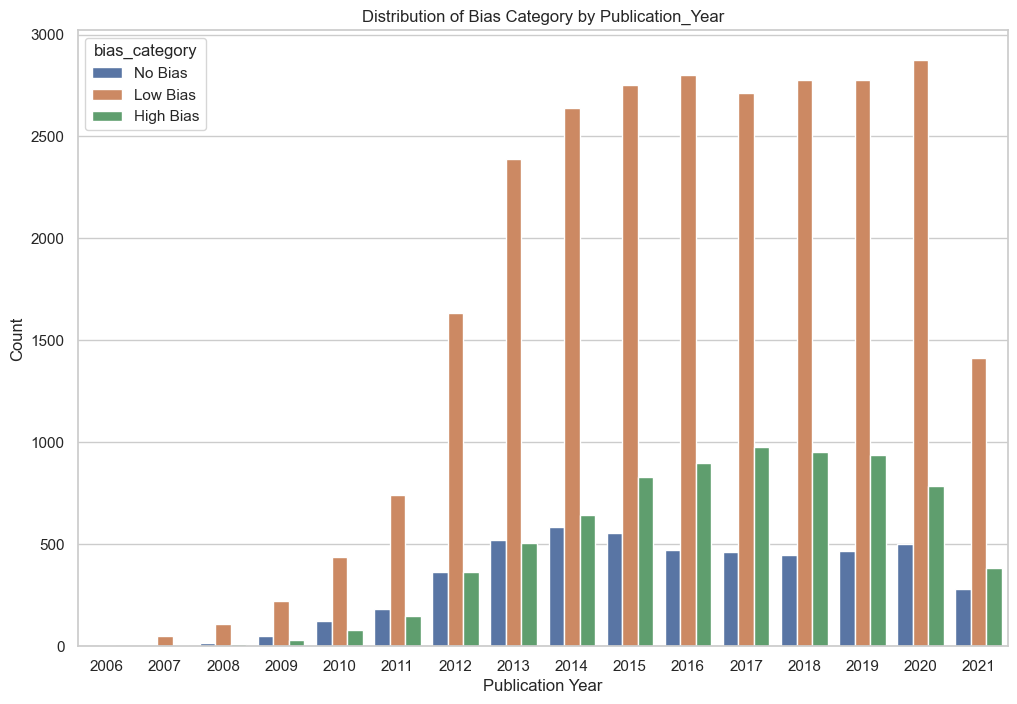

In [37]:
# Plotting the distribution of bias_category by Publication_Year

# Setting the style for seaborn
sns.set(style="whitegrid")

# Setting fig size, plotting feature interaction, setting axes titles and labels
plt.figure(figsize=(12, 8))
sns.countplot(x="Publication_Year", hue="bias_category", data=headlines_filtered)
plt.title('Distribution of Bias Category by Publication_Year')
plt.xlabel('Publication Year')
plt.ylabel('Count')

# Showing the plot
plt.show()

/var/folders/xl/6sfvtvk54y1982txcc62tyqw0000gn/T/ipykernel_6391/466765508.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  violin = sns.violinplot(x='bias_category', y='sentiment_polarity', data=headlines_filtered, inner='quartile', palette='viridis')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


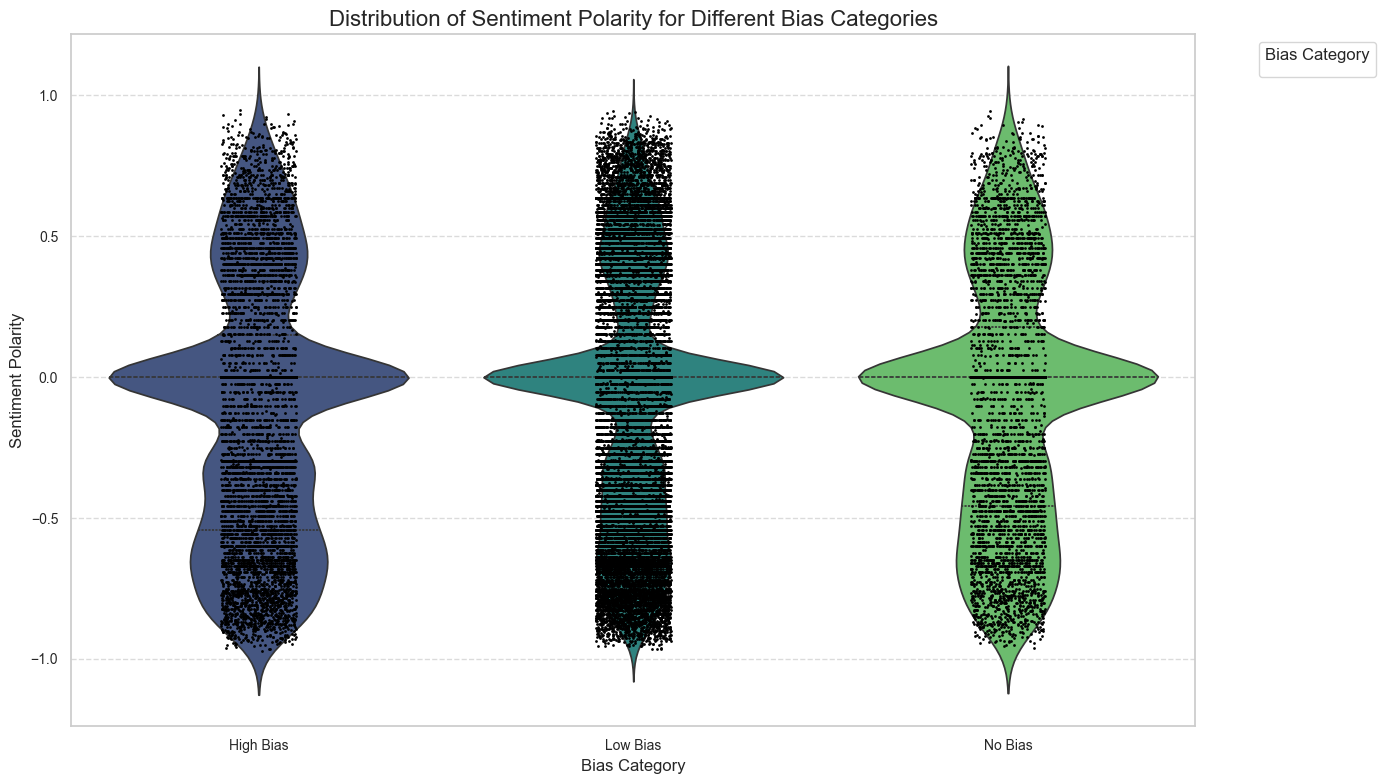

In [38]:
# Setting a Seaborn style
sns.set(style="whitegrid")

# Setting fig size, creating plot of feature interaction
plt.figure(figsize=(14, 8))

# Creating a violin plot with strip plot overlay
violin = sns.violinplot(x='bias_category', y='sentiment_polarity', data=headlines_filtered, inner='quartile', palette='viridis')
strip = sns.stripplot(x='bias_category', y='sentiment_polarity', data=headlines_filtered, color='black', size=2, jitter=True)

# Styling the plot
plt.title('Distribution of Sentiment Polarity for Different Bias Categories', fontsize=16)
plt.xlabel('Bias Category', fontsize=12)
plt.ylabel('Sentiment Polarity', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding a legend
plt.legend(title='Bias Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Showing the plot
plt.tight_layout()
plt.show()


In [39]:
# Renaming the 'headlines_no_site' column to 'headlines'
headlines_filtered.rename(columns={'headline_no_site': 'headlines'}, inplace=True)

headlines_filtered['headlines'].head()

9207           Mother and Daughter Reunite After 82 Years
9208    Hayden Panettiere 'Happy' to Stand Up for Wome...
9209    Woman Gets Trendy Tattoo to 'Caution' People S...
9210    Timeline of Alleged Abduction and Slaying of 1...
9211    Unabomber Ted Kaczynski's Brother, Sister in L...
Name: headlines, dtype: object

In [40]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
import gensim
import gensim.downloader
from gensim.utils import simple_preprocess

In [41]:
# Tokenize, Clean, and Lemmatize Text

# Tokenizing the headline text
headlines_filtered['tokenized_text'] = headlines_filtered['headlines'].apply(word_tokenize)

# Removing non-alphabetic characters, handle empty strings, and extra spaces
headlines_filtered['cleaned_text'] = headlines_filtered['tokenized_text'].apply(lambda tokens: [re.sub(r'[^a-zA-Z0-9]', '', token).strip() for token in tokens if re.sub(r'[^a-zA-Z0-9]', '', token).strip()])

# Converting to lowercase
headlines_filtered['cleaned_text'] = headlines_filtered['cleaned_text'].apply(lambda tokens: [token.lower() for token in tokens])

# Lemmatization - this takes a minute or two to run
lemmatizer = WordNetLemmatizer()
headlines_filtered['lemmatized_text'] = headlines_filtered['cleaned_text'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [42]:
# Storing a copy of headlines_filtered_encoded as lemmatized_df
lemmatized_df = headlines_filtered.copy()

In [43]:
# Dropping the 'headlines' column from lemmatized_df
lemmatized_df.drop('headlines', axis=1, inplace=True)

# Displaying the first row of lemmatized_df after dropping the column
lemmatized_df.head(1)

,site,country,sentiment_polarity,Day_of_Week,Month,Hour_of_Day,Publication_Year,Word_Count,Text_Length,bias_category,tokenized_text,cleaned_text,lemmatized_text
9207,abcnews.go.com,USA,0.0,Wednesday,2,8,2016,7,42,High Bias,"[Mother, and, Daughter, Reunite, After, 82, Ye...","[mother, and, daughter, reunite, after, 82, ye...","[mother, and, daughter, reunite, after, 82, year]"


In [44]:
# Getting stop words
stop_words = set(stopwords.words('english'))

# Creating no stopwords feature, removing stop words from the lemmatized_text column
lemmatized_df['lemmatized_text_no_stopwords'] = lemmatized_df['lemmatized_text'].apply(lambda tokens: [token for token in tokens if token not in stop_words])

In [45]:
# Inspecting head of lemmatized_text_no_stopwords feature
lemmatized_df['lemmatized_text_no_stopwords'].head()

9207                [mother, daughter, reunite, 82, year]
9208    [hayden, panettiere, happy, stand, woman, post...
9209    [woman, get, trendy, tattoo, caution, people, ...
9210    [timeline, alleged, abduction, slaying, 13, ye...
9211    [unabomber, ted, kaczynski, brother, sister, l...
Name: lemmatized_text_no_stopwords, dtype: object

In [46]:
# Storing a copy of lemmatized_df as df_to_vectorize
df_to_vectorize = lemmatized_df.copy()

In [47]:
# Setting list of columns to drop
columns_to_drop = ['tokenized_text', 'cleaned_text', 'lemmatized_text']

# Dropping the specified columns
df_to_vectorize.drop(columns=columns_to_drop, inplace=True)

In [48]:
# Inspecting head 
df_to_vectorize.head(1)

,site,country,sentiment_polarity,Day_of_Week,Month,Hour_of_Day,Publication_Year,Word_Count,Text_Length,bias_category,lemmatized_text_no_stopwords
9207,abcnews.go.com,USA,0.0,Wednesday,2,8,2016,7,42,High Bias,"[mother, daughter, reunite, 82, year]"


In [49]:
# Printing available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [50]:
# Downloading a pre-trained word embedding model and assigning it to 'model'- this will take a while! 
model = gensim.downloader.load('fasttext-wiki-news-subwords-300')

In [51]:
# Defining function
def text2vec(text):
    
    tokenized = text
    
    word_embeddings = [np.zeros(300)]
    for word in tokenized:
        if word in model:
            vector = model[word]
        else:
            vector = np.zeros(300)
            
        word_embeddings.append(vector)
    
    text_embedding = np.stack(word_embeddings).mean(axis=0)
    
    return text_embedding

In [52]:
# Applying the function over the lemmatized text column and assigning the results to new columns
df_to_vectorize['headline_vectors'] = df_to_vectorize['lemmatized_text_no_stopwords'].apply(lambda x: text2vec(x))

In [53]:
# Inspecting headline vectors
df_to_vectorize['headline_vectors'].head()

9207    [-0.010114432700599233, 0.02315941619842003, 0...
9208    [-0.018402375280857086, -0.012355675251455978,...
9209    [-0.012091000284999608, -0.0066915501840412615...
9210    [-0.005805909133050591, 0.009975600615143776, ...
9211    [-0.01995395952835679, -0.022855930007062854, ...
Name: headline_vectors, dtype: object

In [54]:
# Making copy of df_to_vectorize
final_df = df_to_vectorize.copy()

In [55]:
# Dropping the 'lemmatized_text_no_stopwords' column
final_df = final_df.drop('lemmatized_text_no_stopwords', axis=1)

In [56]:
# Checking headlines vectors of first row in filtered dataset
final_df['headline_vectors'][9207]

array([-1.01144327e-02,  2.31594162e-02,  3.38478331e-02, -2.61983400e-03,
        3.62601659e-02, -1.06493332e-02, -2.57916904e-04, -6.91277822e-02,
        3.44547993e-02, -3.27153669e-02,  2.43166648e-03,  2.58481659e-02,
        1.29131333e-02,  2.27498331e-02, -1.53669997e-02,  1.92172999e-02,
        2.11366670e-02, -2.11813335e-02,  1.02198500e-02,  3.86651834e-02,
       -6.10258337e-03, -4.23399964e-03, -5.46613497e-02,  8.27141653e-02,
        4.34007682e-02, -6.78025023e-03, -3.30020006e-03,  5.34819920e-03,
        2.84163666e-02,  1.97139827e-02,  7.35648190e-03,  1.29883364e-03,
       -2.31769999e-02, -4.24127669e-02, -1.95416656e-02, -4.42306713e-03,
       -3.61550009e-02, -4.07092326e-02,  1.79235004e-02, -1.36735667e-02,
       -6.36928327e-03, -4.02288832e-02,  1.82416600e-03, -3.50693002e-02,
        2.19708999e-02,  7.66333348e-02, -1.09447500e-02, -8.70424982e-03,
       -4.63549979e-03,  1.90033337e-02,  2.40958499e-02, -1.86153332e-02,
        6.97495028e-03,  

In [57]:
# Checking final_df for null values
final_df.isnull().sum()

site                  0
country               0
sentiment_polarity    0
Day_of_Week           0
Month                 0
Hour_of_Day           0
Publication_Year      0
Word_Count            0
Text_Length           0
bias_category         0
headline_vectors      0
dtype: int64

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
final_df.columns

Index(['site', 'country', 'sentiment_polarity', 'Day_of_Week', 'Month',
       'Hour_of_Day', 'Publication_Year', 'Word_Count', 'Text_Length',
       'bias_category', 'headline_vectors'],
      dtype='object')

In [60]:
final_df.dtypes

site                   object
country                object
sentiment_polarity    float64
Day_of_Week            object
Month                   int32
Hour_of_Day             int32
Publication_Year        int32
Word_Count              int64
Text_Length             int64
bias_category          object
headline_vectors       object
dtype: object

In [113]:
final_df['site'].unique()

array(['abcnews.go.com', 'eonline.com', 'nydailynews.com', 'nypost.com',
       'people.com', 'usatoday.com', 'usmagazine.com'], dtype=object)

# ONE HOT ENCODE SITE AND INCLUDE IN MODEL

In [61]:
# Setting X and y variables
X = final_df[['headline_vectors', 'sentiment_polarity']]
y = final_df['bias_category']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (31153, 2)
y_train shape: (31153,)
X_test shape: (7789, 2)
y_test shape: (7789,)


In [62]:
# Ensuring there are no NaN values in y_train
y_train.unique()

array(['Low Bias', 'No Bias', 'High Bias'], dtype=object)

In [63]:
# Ensuring there are no NaN values in y_test
y_test.unique()

array(['High Bias', 'Low Bias', 'No Bias'], dtype=object)

In [64]:
# Converting X_train vectors to arrays
X_train_array = np.array(X_train['headline_vectors'].tolist())

# Converting X_test vectors to arrays
X_test_array = np.array(X_test['headline_vectors'].tolist())

In [65]:
#Import SMOTE
from imblearn.over_sampling import SMOTE

In [66]:
#Initialize SMOTE
smote = SMOTE(random_state=42)

#Apply SMOTE to the training set
X_train_smote, y_train_smote = smote.fit_resample(X_train_array, y_train)

In [67]:
#Convert y_train_smote to a DataFrame
y_train_smote_df = pd.DataFrame({'bias_category': y_train_smote})

In [68]:
y_train_smote_df.value_counts()

bias_category
High Bias        21099
Low Bias         21099
No Bias          21099
Name: count, dtype: int64

# EVAL METRIC TOO USE: WEIGHTED AVG PRECISION

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [70]:
# Create an instance of LogisticRegression with class weights
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model on the training data
logreg_model.fit(X_train_array, y_train)

# Make predictions on the test data
y_pred_lr = logreg_model.predict(X_test_array)

In [71]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

   High Bias       0.62      0.19      0.29      1487
    Low Bias       0.69      0.97      0.81      5244
     No Bias       1.00      0.00      0.00      1058

    accuracy                           0.69      7789
   macro avg       0.77      0.39      0.37      7789
weighted avg       0.72      0.69      0.60      7789



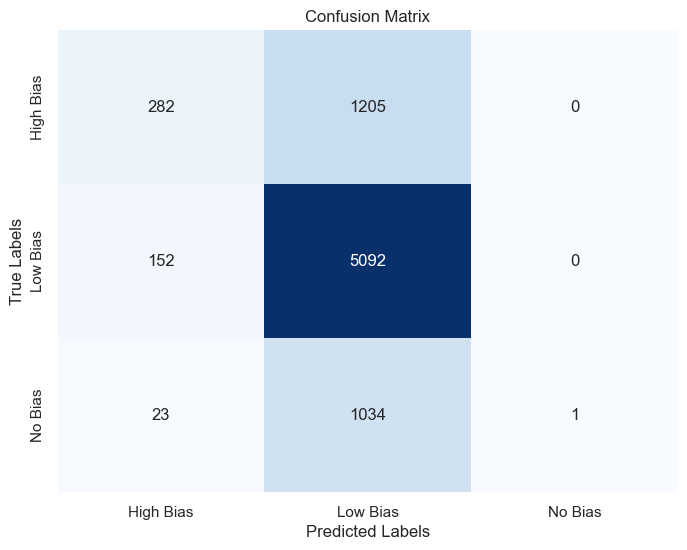

In [72]:
# Get unique classes from y_test
unique_classes = np.unique(y_test)

# Calculate the confusion matrix
logreg_cm = confusion_matrix(y_test, y_pred_lr, labels=unique_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(logreg_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [73]:
logreg_cm

array([[ 282, 1205,    0],
       [ 152, 5092,    0],
       [  23, 1034,    1]])

In [74]:
# Create an instance of RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the training data
rf_model.fit(X_train_array, y_train)

# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test_array)

In [75]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

   High Bias       0.69      0.09      0.15      1487
    Low Bias       0.68      0.99      0.81      5244
     No Bias       0.43      0.00      0.01      1058

    accuracy                           0.68      7789
   macro avg       0.60      0.36      0.32      7789
weighted avg       0.65      0.68      0.57      7789



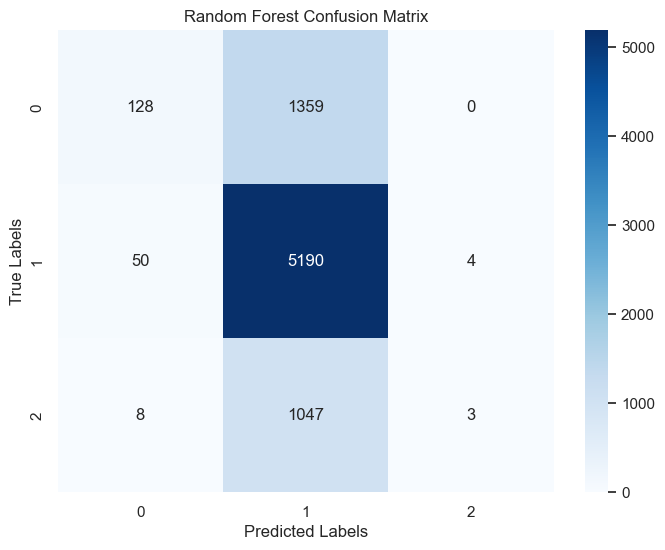

In [76]:
# Create the confusion matrix
rf_cm = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [77]:
rf_cm

array([[ 128, 1359,    0],
       [  50, 5190,    4],
       [   8, 1047,    3]])

In [78]:
# Assuming y_pred_lr and y_pred_rf are the predictions from the models
precision_lr = precision_score(y_test, y_pred_lr, average='macro')
precision_rf = precision_score(y_test, y_pred_rf, average='macro')

print(f"Logistic Regression Model - Macro Average Precision: {precision_lr:.2f}")
print(f"Random Forest Model - Macro Average Precision: {precision_rf:.2f}")

Logistic Regression Model - Macro Average Precision: 0.77
Random Forest Model - Macro Average Precision: 0.60


# RE RUN SIMPLE MODELS USING SMOTED VARIABLES AND COMPARE

In [79]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam

2023-11-28 09:29:23.141549: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [80]:
# Assuming y_train is a pandas Series with string labels
label_encoder = LabelEncoder()

# Encoding y_test and y_train
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encoding y_train_encoded and y_test_encoded
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

# Assuming y_train_encoded is an array of class labels
class_labels = np.unique(y_train_encoded)

In [81]:
# Define the neural network model
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train_array.shape[1], activation='relu'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(len(class_labels), activation='softmax'))

# Compile the model
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
nn_model.fit(X_train_array, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
779/779 [==============================] - 3s 2ms/step - loss: 0.8201 - accuracy: 0.6790 - val_loss: 0.7922 - val_accuracy: 0.6790
Epoch 2/10
779/779 [==============================] - 1s 2ms/step - loss: 0.7670 - accuracy: 0.6906 - val_loss: 0.7645 - val_accuracy: 0.6845
Epoch 3/10
779/779 [==============================] - 1s 2ms/step - loss: 0.7515 - accuracy: 0.6977 - val_loss: 0.7649 - val_accuracy: 0.6856
Epoch 4/10
779/779 [==============================] - 1s 2ms/step - loss: 0.7382 - accuracy: 0.7027 - val_loss: 0.7469 - val_accuracy: 0.6964
Epoch 5/10
779/779 [==============================] - 2s 2ms/step - loss: 0.7282 - accuracy: 0.7086 - val_loss: 0.7444 - val_accuracy: 0.6973
Epoch 6/10
779/779 [==============================] - 2s 2ms/step - loss: 0.7177 - accuracy: 0.7101 - val_loss: 0.7366 - val_accuracy: 0.6972
Epoch 7/10
779/779 [==============================] - 2s 2ms/step - loss: 0.7091 - accuracy: 0.7134 - val_loss: 0.7393 - val_accuracy: 0.6989
Epoch 

In [82]:
# Inspect the mapping between original class labels and encoded numbers
class_labels_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Class Labels Mapping:", class_labels_mapping)

Class Labels Mapping: {'High Bias': 0, 'Low Bias': 1, 'No Bias': 2}


In [83]:
# Make predictions on the test data
nn_model_y_pred_one_hot = nn_model.predict(X_test_array)

# Convert the predicted probabilities to class labels
nn_model_y_pred_classes = np.argmax(nn_model_y_pred_one_hot, axis=1)

# Print classification report
print(classification_report(y_test_encoded, nn_model_y_pred_classes, target_names=label_encoder.classes_))

244/244 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

   High Bias       0.62      0.33      0.43      1487
    Low Bias       0.72      0.93      0.81      5244
     No Bias       0.50      0.11      0.18      1058

    accuracy                           0.70      7789
   macro avg       0.61      0.46      0.47      7789
weighted avg       0.67      0.70      0.65      7789



neural net with dropout rate to prevent overfitting

In [84]:
# Define the neural network model
nn_model_2 = Sequential()
nn_model_2.add(Dense(64, input_dim=X_train_array.shape[1], activation='relu'))
nn_model_2.add(Dropout(0.5))  # Adding dropout rate of 0.5
nn_model_2.add(Dense(32, activation='relu'))
nn_model_2.add(Dropout(0.5))  # Adding dropout rate of 0.5
nn_model_2.add(Dense(len(class_labels), activation='softmax'))

# Compile the model with class weights
nn_model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
nn_model_2.fit(X_train_array, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
779/779 [==============================] - 2s 2ms/step - loss: 0.8552 - accuracy: 0.6774 - val_loss: 0.8185 - val_accuracy: 0.6721
Epoch 2/10
779/779 [==============================] - 2s 2ms/step - loss: 0.8106 - accuracy: 0.6811 - val_loss: 0.7837 - val_accuracy: 0.6776
Epoch 3/10
779/779 [==============================] - 2s 2ms/step - loss: 0.7925 - accuracy: 0.6841 - val_loss: 0.7723 - val_accuracy: 0.6797
Epoch 4/10
779/779 [==============================] - 2s 2ms/step - loss: 0.7821 - accuracy: 0.6854 - val_loss: 0.7659 - val_accuracy: 0.6821
Epoch 5/10
779/779 [==============================] - 2s 2ms/step - loss: 0.7734 - accuracy: 0.6864 - val_loss: 0.7620 - val_accuracy: 0.6811
Epoch 6/10
779/779 [==============================] - 2s 2ms/step - loss: 0.7687 - accuracy: 0.6884 - val_loss: 0.7569 - val_accuracy: 0.6887
Epoch 7/10
779/779 [==============================] - 2s 2ms/step - loss: 0.7638 - accuracy: 0.6906 - val_loss: 0.7518 - val_accuracy: 0.6898
Epoch 

In [85]:
# Make predictions on the test data
nn_model_2_y_pred_one_hot = nn_model_2.predict(X_test_array)

# Convert the predicted probabilities to class labels
nn_model_2_y_pred_classes = np.argmax(nn_model_2_y_pred_one_hot, axis=1)

# Print classification report
print(classification_report(y_test_encoded, nn_model_2_y_pred_classes, target_names=label_encoder.classes_))

244/244 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

   High Bias       0.67      0.20      0.31      1487
    Low Bias       0.70      0.97      0.81      5244
     No Bias       0.00      0.00      0.00      1058

    accuracy                           0.69      7789
   macro avg       0.45      0.39      0.37      7789
weighted avg       0.60      0.69      0.61      7789



/opt/anaconda3/envs/my-new-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/my-new-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/my-new-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


neural network with l2 regularization

In [86]:
from tensorflow.keras.regularizers import l2

# Define the simple neural network model
nn_model_3 = Sequential()
nn_model_3.add(Dense(64, input_dim=X_train_array.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
nn_model_3.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
nn_model_3.add(Dense(len(class_labels), activation='softmax'))

# Compile the model with class weights
nn_model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
nn_model_3.fit(X_train_array, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
779/779 [==============================] - 2s 2ms/step - loss: 0.9625 - accuracy: 0.6782 - val_loss: 0.8554 - val_accuracy: 0.6721
Epoch 2/10
779/779 [==============================] - 2s 3ms/step - loss: 0.8462 - accuracy: 0.6786 - val_loss: 0.8531 - val_accuracy: 0.6721
Epoch 3/10
779/779 [==============================] - 2s 2ms/step - loss: 0.8450 - accuracy: 0.6786 - val_loss: 0.8526 - val_accuracy: 0.6721
Epoch 4/10
779/779 [==============================] - 2s 2ms/step - loss: 0.8446 - accuracy: 0.6786 - val_loss: 0.8527 - val_accuracy: 0.6721
Epoch 5/10
779/779 [==============================] - 1s 2ms/step - loss: 0.8445 - accuracy: 0.6786 - val_loss: 0.8524 - val_accuracy: 0.6721
Epoch 6/10
779/779 [==============================] - 1s 2ms/step - loss: 0.8444 - accuracy: 0.6786 - val_loss: 0.8524 - val_accuracy: 0.6721
Epoch 7/10
779/779 [==============================] - 2s 2ms/step - loss: 0.8442 - accuracy: 0.6786 - val_loss: 0.8529 - val_accuracy: 0.6721
Epoch 

In [87]:
# Make predictions on the test data
nn_model_3_y_pred_one_hot = nn_model_3.predict(X_test_array)

# Convert the predicted probabilities to class labels
nn_model_3_y_pred_classes = np.argmax(nn_model_3_y_pred_one_hot, axis=1)

# Print classification report
print(classification_report(y_test_encoded, nn_model_3_y_pred_classes, target_names=label_encoder.classes_))

244/244 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

   High Bias       0.00      0.00      0.00      1487
    Low Bias       0.67      1.00      0.80      5244
     No Bias       0.00      0.00      0.00      1058

    accuracy                           0.67      7789
   macro avg       0.22      0.33      0.27      7789
weighted avg       0.45      0.67      0.54      7789



/opt/anaconda3/envs/my-new-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/my-new-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/my-new-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


neural network with batch normalizatiton

In [89]:
# Define the neural network model
nn_model_4 = Sequential()
nn_model_4.add(Dense(64, input_dim=X_train_array.shape[1], activation='relu'))
nn_model_4.add(BatchNormalization())
nn_model_4.add(Dense(32, activation='relu'))
nn_model_4.add(BatchNormalization())
nn_model_4.add(Dense(len(class_labels), activation='softmax'))

# Compile the model with class weights
nn_model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
nn_model_4.fit(X_train_array, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
779/779 [==============================] - 4s 3ms/step - loss: 0.8493 - accuracy: 0.6519 - val_loss: 0.7938 - val_accuracy: 0.6689
Epoch 2/10
779/779 [==============================] - 2s 3ms/step - loss: 0.7482 - accuracy: 0.6997 - val_loss: 0.7677 - val_accuracy: 0.6854
Epoch 3/10
779/779 [==============================] - 2s 3ms/step - loss: 0.7307 - accuracy: 0.7037 - val_loss: 0.7632 - val_accuracy: 0.6848
Epoch 4/10
779/779 [==============================] - 2s 3ms/step - loss: 0.7152 - accuracy: 0.7085 - val_loss: 0.7605 - val_accuracy: 0.6843
Epoch 5/10
779/779 [==============================] - 2s 3ms/step - loss: 0.6993 - accuracy: 0.7147 - val_loss: 0.7419 - val_accuracy: 0.6991
Epoch 6/10
779/779 [==============================] - 2s 2ms/step - loss: 0.6921 - accuracy: 0.7182 - val_loss: 0.7517 - val_accuracy: 0.6917
Epoch 7/10
779/779 [==============================] - 2s 3ms/step - loss: 0.6810 - accuracy: 0.7241 - val_loss: 0.7669 - val_accuracy: 0.6931
Epoch 

In [90]:
# Make predictions on the test data
nn_model_4_y_pred_one_hot = nn_model_4.predict(X_test_array)

# Convert the predicted probabilities to class labels
nn_model_4_y_pred_classes = np.argmax(nn_model_4_y_pred_one_hot, axis=1)

# Print classification report
print(classification_report(y_test_encoded, nn_model_4_y_pred_classes, target_names=label_encoder.classes_))

244/244 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

   High Bias       0.57      0.34      0.43      1487
    Low Bias       0.72      0.91      0.81      5244
     No Bias       0.45      0.11      0.17      1058

    accuracy                           0.69      7789
   macro avg       0.58      0.45      0.47      7789
weighted avg       0.65      0.69      0.65      7789



nn with leaky relu

In [91]:
# Define the neural network model
nn_model_5 = Sequential()
nn_model_5.add(Dense(64, input_dim=X_train_array.shape[1]))
nn_model_5.add(LeakyReLU(alpha=0.1))  # Leaky ReLU activation
nn_model_5.add(BatchNormalization())
nn_model_5.add(Dense(32))
nn_model_5.add(LeakyReLU(alpha=0.1))  # Leaky ReLU activation
nn_model_5.add(BatchNormalization())
nn_model_5.add(Dense(len(class_labels), activation='softmax'))

# Compile the model with class weights
nn_model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
nn_model_5.fit(X_train_array, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
779/779 [==============================] - 4s 3ms/step - loss: 0.8427 - accuracy: 0.6532 - val_loss: 0.7754 - val_accuracy: 0.6861
Epoch 2/10
779/779 [==============================] - 2s 3ms/step - loss: 0.7439 - accuracy: 0.7002 - val_loss: 0.7591 - val_accuracy: 0.6912
Epoch 3/10
779/779 [==============================] - 2s 2ms/step - loss: 0.7254 - accuracy: 0.7053 - val_loss: 0.7719 - val_accuracy: 0.6877
Epoch 4/10
779/779 [==============================] - 2s 2ms/step - loss: 0.7145 - accuracy: 0.7091 - val_loss: 0.7561 - val_accuracy: 0.6927
Epoch 5/10
779/779 [==============================] - 2s 2ms/step - loss: 0.7007 - accuracy: 0.7128 - val_loss: 0.7682 - val_accuracy: 0.6885
Epoch 6/10
779/779 [==============================] - 2s 3ms/step - loss: 0.6882 - accuracy: 0.7146 - val_loss: 0.7554 - val_accuracy: 0.6952
Epoch 7/10
779/779 [==============================] - 2s 3ms/step - loss: 0.6782 - accuracy: 0.7221 - val_loss: 0.7725 - val_accuracy: 0.6829
Epoch 

In [92]:
# Make predictions on the test data
nn_model_5_y_pred_one_hot = nn_model_5.predict(X_test_array)

# Convert the predicted probabilities to class labels
nn_model_5_y_pred_classes = np.argmax(nn_model_5_y_pred_one_hot, axis=1)

# Print classification report
print(classification_report(y_test_encoded, nn_model_5_y_pred_classes, target_names=label_encoder.classes_))

244/244 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

   High Bias       0.56      0.40      0.47      1487
    Low Bias       0.73      0.88      0.80      5244
     No Bias       0.39      0.15      0.22      1058

    accuracy                           0.69      7789
   macro avg       0.56      0.48      0.49      7789
weighted avg       0.65      0.69      0.66      7789



lowering learning rate, adding epochs to 50

In [93]:
# Define the neural network model
nn_model_6 = Sequential()
nn_model_6.add(Dense(64, input_dim=X_train_array.shape[1]))
nn_model_6.add(LeakyReLU(alpha=0.1))  # Leaky ReLU activation
nn_model_6.add(BatchNormalization())
nn_model_6.add(Dense(32))
nn_model_6.add(LeakyReLU(alpha=0.1))  # Leaky ReLU activation
nn_model_6.add(BatchNormalization())
nn_model_6.add(Dense(len(class_labels), activation='softmax'))

# Compile the model with a faster learning rate
nn_model_6.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
nn_model_6.fit(X_train_array, y_train_one_hot, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
779/779 [==============================] - 3s 3ms/step - loss: 0.7950 - accuracy: 0.6812 - val_loss: 0.7659 - val_accuracy: 0.6853
Epoch 2/50
779/779 [==============================] - 2s 3ms/step - loss: 0.7520 - accuracy: 0.6965 - val_loss: 0.7664 - val_accuracy: 0.6851
Epoch 3/50
779/779 [==============================] - 2s 3ms/step - loss: 0.7424 - accuracy: 0.7000 - val_loss: 0.7554 - val_accuracy: 0.6943
Epoch 4/50
779/779 [==============================] - 2s 3ms/step - loss: 0.7360 - accuracy: 0.7017 - val_loss: 0.7820 - val_accuracy: 0.6880
Epoch 5/50
779/779 [==============================] - 2s 3ms/step - loss: 0.7293 - accuracy: 0.7044 - val_loss: 0.7629 - val_accuracy: 0.6903
Epoch 6/50
779/779 [==============================] - 3s 3ms/step - loss: 0.7233 - accuracy: 0.7041 - val_loss: 0.7507 - val_accuracy: 0.6994
Epoch 7/50
779/779 [==============================] - 3s 4ms/step - loss: 0.7180 - accuracy: 0.7079 - val_loss: 0.7504 - val_accuracy: 0.7010
Epoch 

In [94]:
# Make predictions on the test data
nn_model_6_y_pred_one_hot = nn_model_6.predict(X_test_array)

# Convert the predicted probabilities to class labels
nn_model_6_y_pred_classes = np.argmax(nn_model_6_y_pred_one_hot, axis=1)

# Print classification report
print(classification_report(y_test_encoded, nn_model_6_y_pred_classes, target_names=label_encoder.classes_))

244/244 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

   High Bias       0.48      0.48      0.48      1487
    Low Bias       0.73      0.83      0.78      5244
     No Bias       0.38      0.13      0.19      1058

    accuracy                           0.67      7789
   macro avg       0.53      0.48      0.48      7789
weighted avg       0.64      0.67      0.64      7789



smoted nn with simple architecture

In [95]:
# Convert labels to categorical
label_encoder = LabelEncoder()
y_train_smote_encoded = label_encoder.fit_transform(y_train_smote)
y_train_smote_one_hot = to_categorical(y_train_smote_encoded)

# Define the neural network model
nn_model_7 = Sequential()
nn_model_7.add(Dense(64, input_dim=X_train_smote.shape[1], activation='relu'))
nn_model_7.add(Dense(32, activation='relu'))
nn_model_7.add(Dense(len(class_labels), activation='softmax'))

# Compile the model
nn_model_7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
nn_model_7.fit(X_train_smote, y_train_smote_one_hot, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1583/1583 [==============================] - 4s 2ms/step - loss: 0.8905 - accuracy: 0.5859 - val_loss: 1.4879 - val_accuracy: 0.0183
Epoch 2/10
1583/1583 [==============================] - 3s 2ms/step - loss: 0.8053 - accuracy: 0.6330 - val_loss: 1.4495 - val_accuracy: 0.0785
Epoch 3/10
1583/1583 [==============================] - 4s 3ms/step - loss: 0.7605 - accuracy: 0.6594 - val_loss: 1.5791 - val_accuracy: 0.0610
Epoch 4/10
1583/1583 [==============================] - 4s 2ms/step - loss: 0.7243 - accuracy: 0.6808 - val_loss: 1.3549 - val_accuracy: 0.1956
Epoch 5/10
1583/1583 [==============================] - 3s 2ms/step - loss: 0.6921 - accuracy: 0.6978 - val_loss: 1.1352 - val_accuracy: 0.2601
Epoch 6/10
1583/1583 [==============================] - 3s 2ms/step - loss: 0.6636 - accuracy: 0.7124 - val_loss: 1.0967 - val_accuracy: 0.3840
Epoch 7/10
1583/1583 [==============================] - 4s 2ms/step - loss: 0.6369 - accuracy: 0.7262 - val_loss: 1.2280 - val_accuracy:

In [96]:
# Make predictions on the test set
y_pred_nn_7 = nn_model_7.predict(X_test_array)

# Convert predictions to class labels
y_pred_nn_7_labels = label_encoder.inverse_transform(y_pred_nn_7.argmax(axis=1))

# Print the classification report
print(classification_report(y_test, y_pred_nn_7_labels))

244/244 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

   High Bias       0.41      0.63      0.50      1487
    Low Bias       0.76      0.69      0.72      5244
     No Bias       0.33      0.23      0.27      1058

    accuracy                           0.62      7789
   macro avg       0.50      0.52      0.50      7789
weighted avg       0.63      0.62      0.62      7789



Macro Average Precision Scores across all NN models:

nn model 6 = .53 (nn with lower learning rate, epochs to 50)
nn model 5 = .56 (nn with leaky relu)
nn model 4 = .58 (nn with batch normalization)
nn model 3 = .22 (nn with l2 regularization)
nn model 2 = .45 (nn with dropout rate of .5)
nn model 1 = .61 (simple nn)

things to try:
apply smote to model 1
learning rate schedule
add 50 epochs to model 1, keeping learning rate constant from original architecture
SGD optimizer
grid search
add or subtract layers?

nn model 7 = .5 (smoted nn)
nn model 8 = 

In [106]:
import keras
from scikeras.wrappers import KerasClassifier